#### aula 1: metricas de validação

In [ ]:
import pandas as pd
import os
import sqlalchemy
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing

TRAIN_DIR = os.path.join(os.path.abspath('.'), 'src', 'ep07', 'model_churn', 'modeling', 'train')
MODELING_DIR = os.path.dirname(TRAIN_DIR)
BASE_DIR = os.path.dirname(MODELING_DIR)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(BASE_DIR))), 'data')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

engine = sqlalchemy.create_engine("sqlite:///" + os.path.join(DATA_DIR, 'olist.db'))

abt = pd.read_sql_table('tb_abt_churn', engine)

df_oot = abt[abt['dt_ref'] == abt['dt_ref'].max()].copy() # Filtrando base out of time
df_oot.reset_index(drop=True, inplace=True)

df_abt = abt[abt['dt_ref'] < abt['dt_ref'].max()].copy() # Filtrando base abt

# Definindo variáveis
target = 'flag_churn' # Resposta
to_remove = ['dt_ref', 'seller_city', 'seller_id', target] # Variáveis para retirar das analises

features = df_abt.columns.tolist() # Todas variáveis do dataset
for f in to_remove:
    features.remove(f) # Remove uma variável por vez, das que devem ser removidas

cat_features = df_abt[features].dtypes[df_abt[features].dtypes == 'object'].index.tolist()
num_features = list(set(features) - set(cat_features))

# Separando entre treino e teste
X = df_abt[features] # matriz de features ou variáveis
y = df_abt[target] # Vetor da resposta ou target

# Separa treino e validação
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=1992)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

onehot = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot.fit(X_train[cat_features])

onehot_df = pd.DataFrame(onehot.transform(X_train[cat_features]),
                         columns=onehot.get_feature_names(cat_features))

df_train = pd.concat([X_train[num_features], onehot_df], axis=1)
features_fit = df_train.columns.tolist()
# Modelo
clf = tree.DecisionTreeClassifier(min_samples_leaf=100)
clf.fit(df_train[features_fit], y_train)

# Importância das variáveis
pd.Series(clf.feature_importances_, index=df_train.columns).sort_values(ascending=False)[:10]

# Análise na base de treino
y_train_pred = clf.predict(df_train)
y_train_proba = clf.predict_proba(df_train)
acc_train = metrics.accuracy_score(y_train, y_train_pred)
print("Base Treino:", acc_train)

# Análise na base de teste
onehot_df_test = pd.DataFrame(onehot.transform(X_test[cat_features]),
                              columns=onehot.get_feature_names(cat_features))

df_predict = pd.concat([X_test[num_features], onehot_df_test], axis=1)
y_test_pred = clf.predict(df_predict)
# Análise na base de teste
acc_test = metrics.accuracy_score(y_test, y_test_pred)
print("Base Teste:", acc_test)

# Análise na base de oot
onehot_df_oot = pd.DataFrame(onehot.transform(df_oot[cat_features]),
                             columns=onehot.get_feature_names(cat_features))
df_oot_predict = pd.concat([df_oot[num_features], onehot_df_oot], axis=1)
oot_pred = clf.predict(df_oot_predict)
acc_oot = metrics.accuracy_score(df_oot[target], oot_pred)
print("Base out of time:", acc_oot)

# Fazendo o predict
df_abt_onehot = pd.DataFrame(onehot.transform(abt[cat_features]),
                             columns=onehot.get_feature_names(cat_features))
df_abt_predict = pd.concat([abt[num_features], df_abt_onehot], axis=1)

probs = clf.predict_proba(df_abt_predict)
abt['score_churn'] = clf.predict_proba(df_abt_predict)[:, 1]
abt_score = abt[['dt_ref', 'seller_id', 'score_churn']]


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

#### aula 2 : Machine Learning Models with SHAP


In [ ]:
import shap
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [ ]:
data = load_breast_cancer()
X, y = data['data'], data['target']
data['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

In [ ]:
clf.score(X_test, y_test)

0.956140350877193

In [ ]:
clf.predict([X_test[0]])

array([0])

In [ ]:
explainer = shap.KernelExplainer(clf.predict, shap.kmeans(X_train, 10))

In [ ]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/114 [00:00<?, ?it/s]

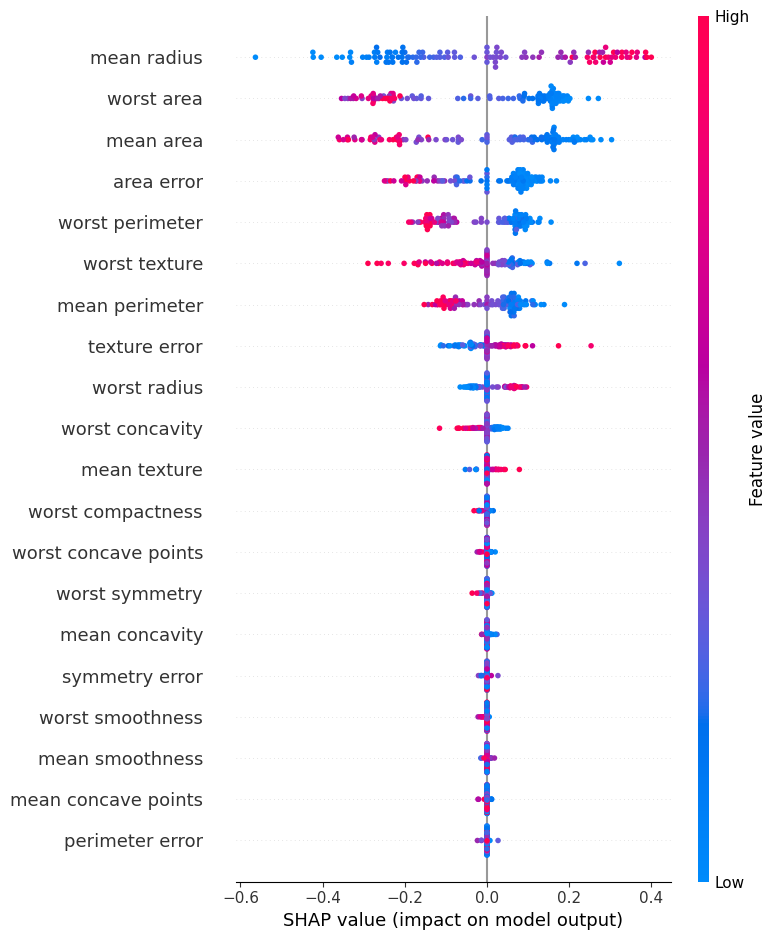

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=data['feature_names'])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=data['feature_names'])

In [ ]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

In [ ]:
feature_names = data['feature_names']
feature_importance = zip(feature_names, mean_abs_shap_values)

In [ ]:
sorted_feature_importances = sorted(feature_importance, key=lambda x: x[1], reverse=True)

In [ ]:
for feature, importance in sorted_feature_importances:
    print(feature, ':', importance)

mean radius : 0.2138943470918281
worst area : 0.17997862072639914
mean area : 0.1750729384816708
area error : 0.10136347893323765
worst perimeter : 0.09372572415891728
worst texture : 0.07108255788036145
mean perimeter : 0.07031669217102543
texture error : 0.03744808707900938
worst radius : 0.03152125067071409
worst concavity : 0.01762291429941775
mean texture : 0.004972302832877156
worst compactness : 0.0017103080362091618
worst concave points : 0.0015515473699389034
worst symmetry : 0.0015286156707303908
mean concavity : 0.0014271878321391327
symmetry error : 0.0009671026482417368
worst smoothness : 0.0008285112683572446
mean smoothness : 0.0007948132457793424
mean concave points : 0.0007715839825570512
perimeter error : 0.0007428959626602682
mean compactness : 0.0007237414798369383
concavity error : 0.0006794255219790212
smoothness error : 0.0005345691258762358
compactness error : 0.0005204776823037576
mean fractal dimension : 0.0004805621589298295
fractal dimension error : 0.000376